# NeuralMagic - LLMCompressor

* A unified library for creating compressed models for faster inference with vLLM(Inference and Serving Library - Paged Attention).

* Supports two types of Kernels -> [Marlin](https://github.com/IST-DASLab/marlin) - mixed precision matrix multiplication kernel - FP16XInt4 with batch size upto 32. and Custom CUTLASS Kernel for INT8 and FP8 kernels.
    
    * asynchronous global weight loads, circular shared memory queue, task scheduling and synchronization.
 
* Singe Library has been built ground up to integrate GPTQ, SmoothQuant and provide support for huggingface models. Previous fragmented ecosystem of bespoke compression - AutoGPTQ, AutoAWQ, AutoFP8


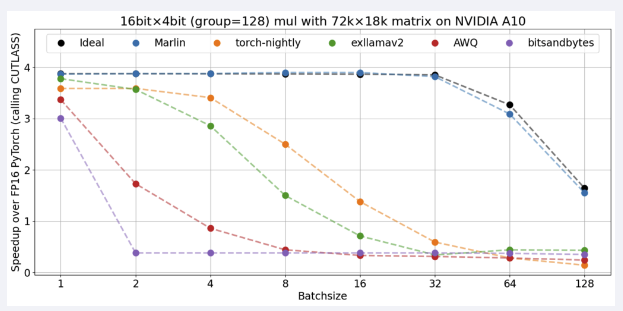


### <font color="yellow">**Quantizing Weight vs Activations**

Quantizing weights is easier than quantizing activations because weights remain constant during inference, while activations change dynamically based on the input. This static nature of weights allows for a simpler quantization process, as the optimal quantization parameters can be determined offline and applied consistently during inference. Quantizing activations, on the other hand, requires real-time quantization during inference, which is more challenging due to the dynamic range and distribution of activation values. Additionally, the impact of quantization errors on activations can propagate through the network, potentially leading to more significant accuracy degradation compared to weight quantization. Therefore, weight quantization is often preferred as a more straightforward approach to reduce model size in LLMs.

Weight-only quantization enables smaller models and faster latency, but with 16-bit activations, the compute runs through the same 16-bit tensor cores as the unquantized model. This leads to slower inference for compute-heavy workloads due to the penalty of dequantizing the weights.

Weight-only quantization often fails to deliver speed improvements in production serving deployments. These environments typically result in compute-bound workloads with minimal benefits from weight-only quantization. Activation quantization, however, offers a substantial performance boost in such high-compute scenarios and faster inference at lower queries per second (QPS). 

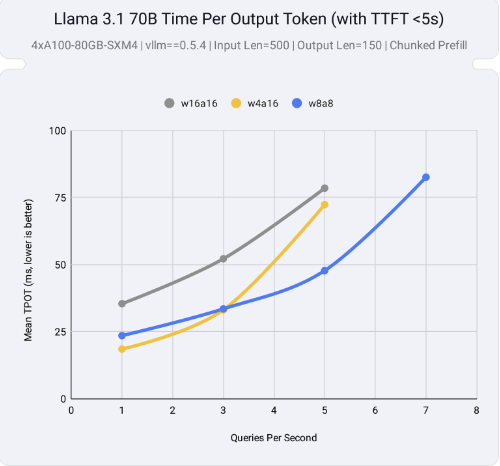

At low QPS, weight-only quantization offers improved latency relative to an unquantized model. However, as the server load increases and becomes compute-bound, the performance of the weight-only model levels off, matching the unquantized model


### <font color="yellow">**Performane degradation with increased batch Size - Why?**

* **Memory Bandwidth Saturation**  : As the batch size increases, more data needs to be transferred between the GPU's memory and its processing units. At a certain point, the memory bandwidth (the rate at which data can be moved) becomes saturated.
Once the memory bandwidth is fully utilized, adding more data (larger batches) doesn't increase processing speed linearly. Instead, the GPU spends more time waiting for data to be moved, leading to a bottleneck.

* **Compute-to-Memory Ratio**  : The compute-to-memory access ratio represents how much work the GPU can do (compute) relative to how much data needs to be moved between memory and the processing units (memory access). Ideally, you want a high ratio, where the GPU is doing lots of computations without being bottlenecked by the time it takes to load data from memory.


### <font color="yellow">**SmoothQuant**

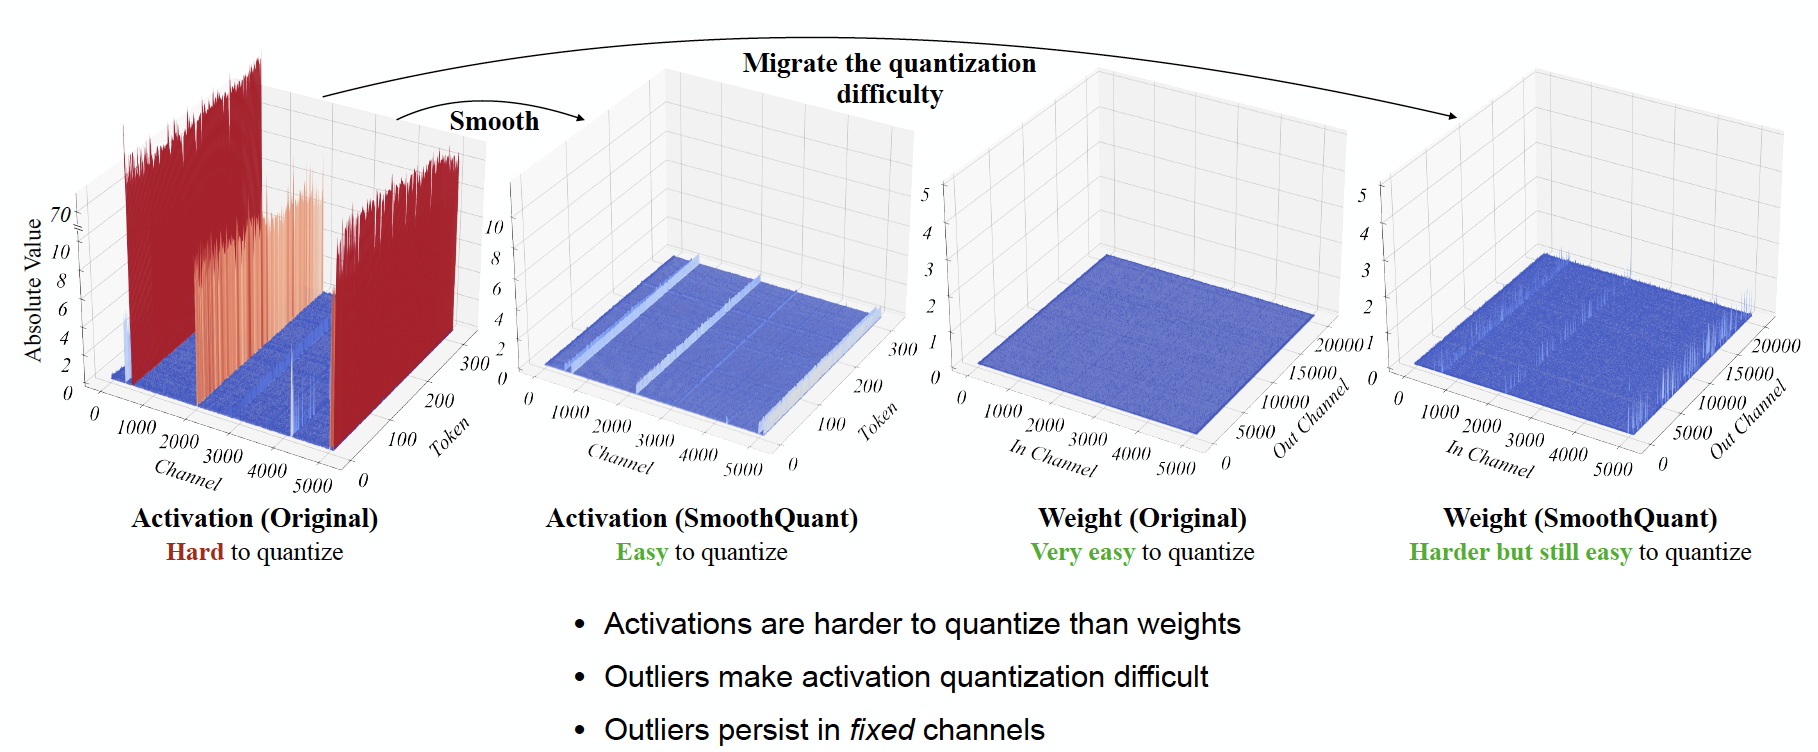

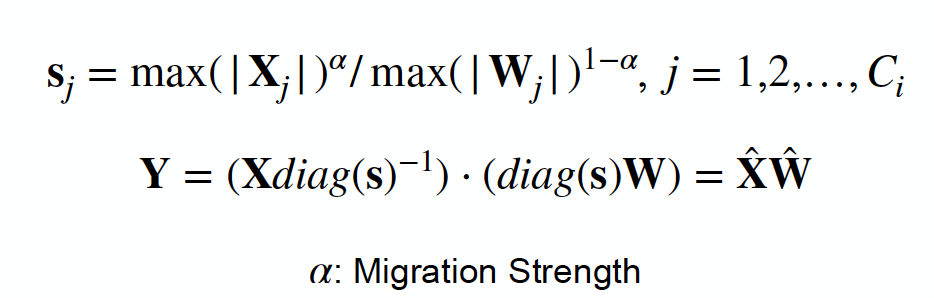

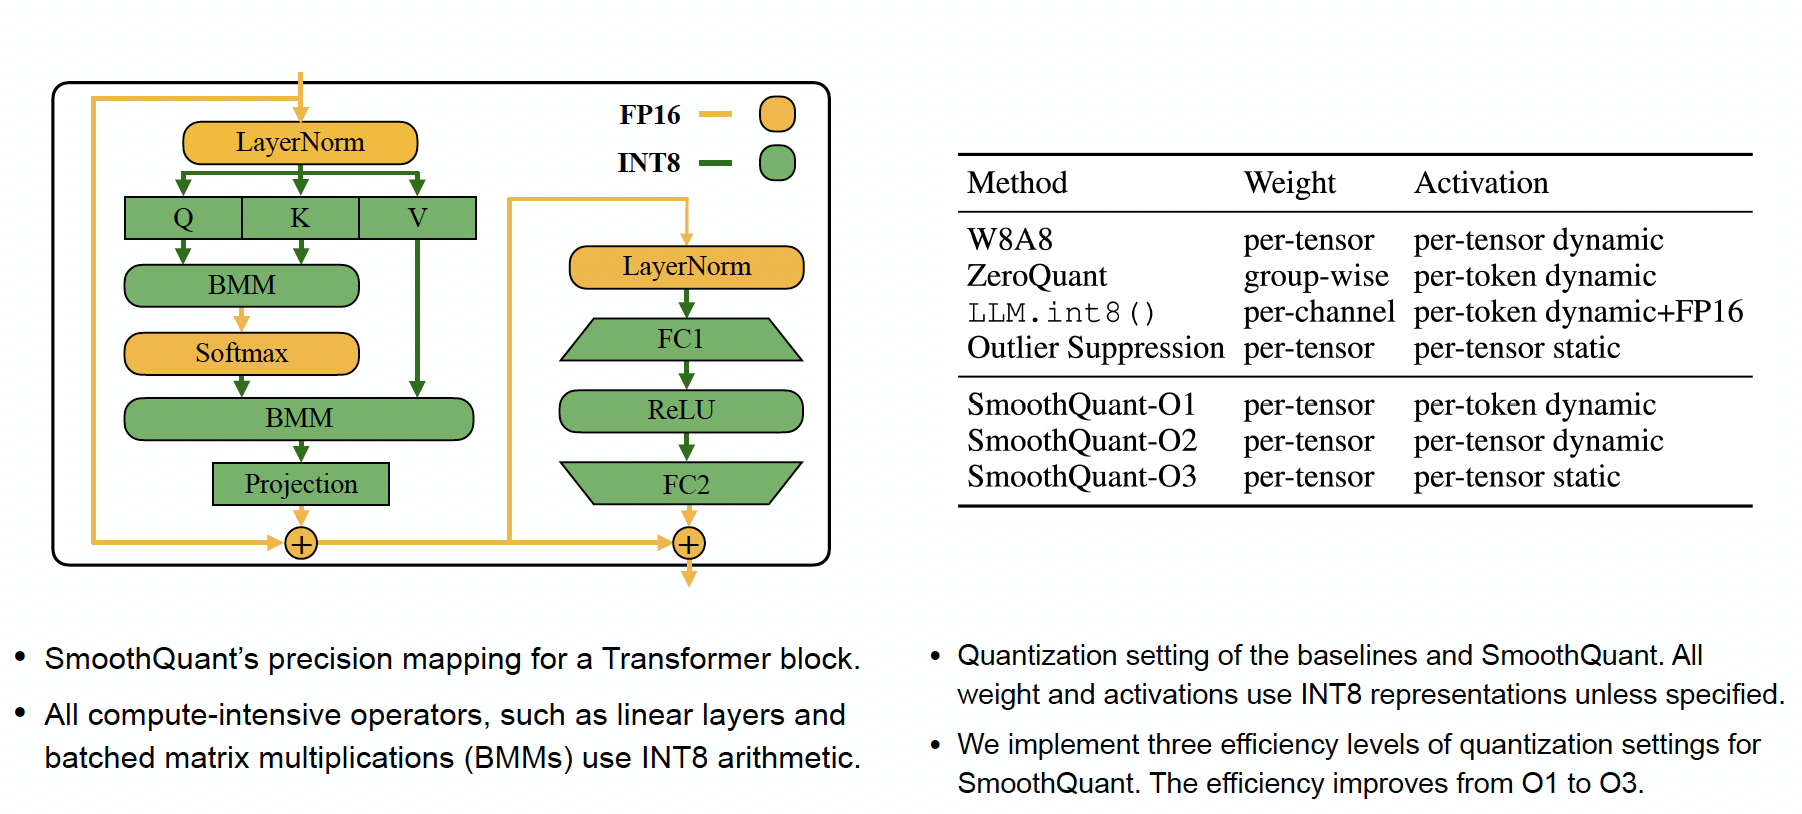


1. Dynamic Range: Activations have a wider range (small to large values, including outliers), making it harder to represent them with fewer bits. Weights are more controlled and easier to scale.

2. Per-Sample Variability: Weights are fixed after training. Activations vary per input, requiring a broader quantization range.

3. Outliers: Activations often have outliers (rare extreme values), making it difficult to balance range and precision.

4. Layer-to-Layer Variability: The distribution of activations changes across layers, requiring different quantization strategies.

5. Nonlinear Operations: Functions like ReLU, softmax, and tanh change activation distributions drastically. Weights don’t undergo these

6. nonlinear transformations, making them easier to handle. 

7. Numerical Stability: Poor quantization of activations directly affects the next layer’s input, leading to potential model degradation.

8. Quantization Noise Sensitivity: Layers like batch normalization - activation quantization noise.



### <font color="yellow"> **Generative Pretrained Transformer - Quantization (GPTQ)**

Jan 2023 - Optimal Brain Compression
March 2023 - GPTQ - IST Austria & NeuralMagic

Optimal Brain Quantization generalizes the classic Optimal Brain Surgeon (OBS) second-order weight pruning framework to apply to quantization. OBQ quantizes weights one by one, in order of quantization error, always adjusting the remaining weights. While these approaches can produce good results for models up to ≈ 100 million parameters in a few GPU hours, scaling them to networks orders of magnitude larger is challenging.


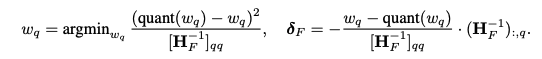

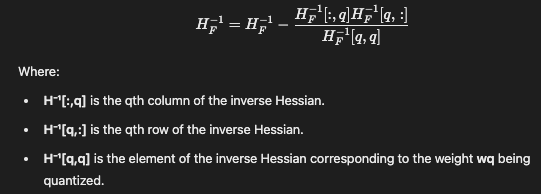

Sherman-Morrison or rank-one update method : 
The Hessian matrix (HF) plays a key role in determining which weights to quantize. It captures the second-order information (curvature) of the weight space and helps in computing the updates necessary after each weight is quantized. OBQ also introduces an efficient way to update the inverse Hessian matrix (denoted as HF⁻¹) after each weight is quantized. This avoids expensive recalculations of the inverse for each update, which greatly reduces computational costs. The method uses Gaussian elimination to efficiently update the inverse of the matrix.

Think of the inverse Hessian as a way to figure out the ripple effect: if you perturb (quantize) one weight, how much should each other weight change to "cancel out" the error introduced? The inverse Hessian tells you how strong this ripple effect is and provides a method for minimizing its impact.

GPT-Q Overall:

* Select weight for Quantization
* Quantize the weights
* Update Other weights
* Iterate over all weights
* Handle Multiple Layers

### <font color="yellow"> **Activation Aware Weight Quantization (AWQ)**

Came from Song Han Lab (2023)

1. Weight Quantization: AWQ starts with standard weight quantization, reducing the precision of the weights to a lower bit-width (typically INT8).

2. Activation Awareness: During quantization, the method takes into account the statistics of the activations. Specifically, it looks at how activations are distributed and how they interact with the weights in each layer. This helps in determining the best way to quantize the weights without causing excessive activation-related errors.

3. Outlier Suppression: AWQ often includes a mechanism to suppress outliers in activations. Outliers (extreme values) can distort the effect of quantized weights and cause large accuracy drops. By suppressing these outliers or adjusting the quantization scheme to handle them, AWQ can minimize the negative impact of quantization.

4. Layer-wise Quantization: Instead of applying the same quantization scheme to the entire model, AWQ often quantizes layer by layer, allowing each layer to use a quantization strategy that best matches the interaction between its weights and activations.


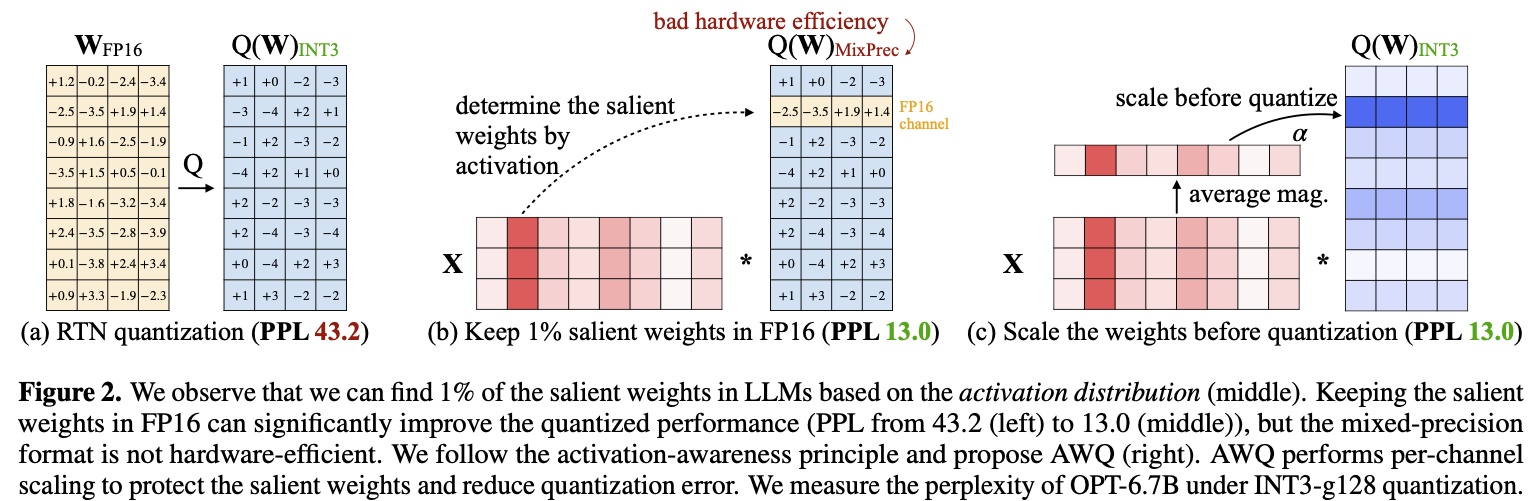

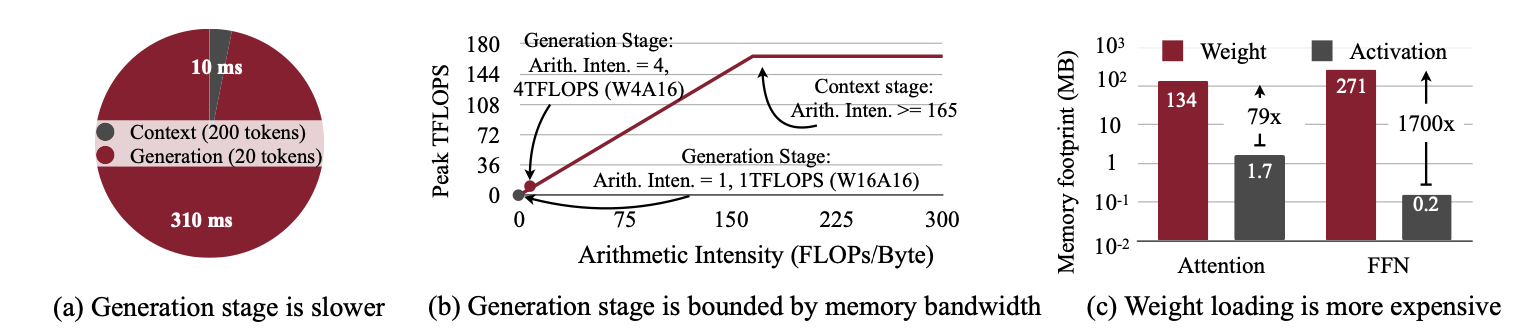

**Activation-Aware Quantization Process**

1. Calibration: Before the quantization, AWQ runs a calibration step where it collects activation statistics (like min/max values, distribution, etc.) from a subset of data (often called a calibration set). This helps to establish how activations behave across the model and helps in designing the quantization scheme.

2. Mapping Activation Distributions: During calibration, AWQ maps the activation distribution to determine the optimal way to represent the activations in lower-precision formats.

3. Fine-tuning Quantized Model: AWQ may include a fine-tuning step where, after initial quantization, the model is re-tuned (using training data) to adjust for the changes caused by the lower-precision weights and activations.


### <font color="yellow"> **Quantization - Dimensionality Strategy**

| **Quantization Type**   | **When to Apply**                                                                                                       | **Advantages**                                              | **Disadvantages**                                          | **Best Use Case**                                           |
|-------------------------|-------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------|------------------------------------------------------------|-------------------------------------------------------------|
| **Per-Token Dynamic**    | - When individual tokens have highly variable activations.<br> - Models where each token’s representation changes drastically, like in **transformers** handling natural language processing (NLP) tasks. | - High precision for individual tokens.<br> - Minimizes quantization error for each token. | - Computationally expensive (scaling calculated per token).<br> - Higher latency due to on-the-fly scaling calculation. | - **Transformers** and **sequence models** (e.g., GPT, BERT, LLaMA) where token-level variability is high.<br> - Applications requiring **high accuracy** for every token (e.g., text generation, machine translation). |
| **Per-Tensor Dynamic**   | - When there’s **moderate variation** in activations across a tensor.<br> - Models that handle entire batches or layers at once, like **CNNs** or dense layers in MLPs.<br> - When real-time adaptation is needed for changing input data. | - Balances precision and efficiency.<br> - Adjusts to the current input data distribution. | - Slightly more computational overhead compared to static.<br> - Still recalculates scaling factors at runtime, which can increase inference time. | - Suitable for **vision models** like **CNNs** or **MLPs** where the activation distribution doesn’t vary drastically across individual tokens but might vary across layers or batches. |
| **Per-Tensor Static**    | - For models where the activation distribution doesn’t vary significantly.<br> - When **speed** is the highest priority and input data remains consistent.<br> - Useful in **real-time** systems where low-latency is critical. | - Extremely fast since scaling is pre-computed.<br> - No need for recalculation during inference.<br> - Low memory and computation overhead. | - Less accurate if the input distribution during inference is different from the one used during calibration.<br> - Fixed scaling factors can lead to information loss for dynamic data. | - **Low-latency applications** like real-time image classification or embedded systems.<br> - **Edge devices** where computational resources are limited and accuracy loss is acceptable.<br> - **Static models** where activations remain relatively stable. |
| **Per-Token Static**     | - Rarely used since token-level static quantization isn’t common.<br> - Could be applied where token activations are known to be very consistent across different inputs. | - Pre-computed scaling reduces real-time overhead. | - Not very useful, as token-level activations often vary significantly. | - Specific niche use cases where token-level activations remain stable.<br> - Rarely applied in practice. |


----------------------------------------------------------------------------------------------------------------------

Sources to Refer: 

[Understanding vLLM working](https://www.hopsworks.ai/dictionary/vllm#:~:text=vLLM%20stands%20for%20Virtual%20Large,authored%20by%20Kwon%20et%20al.) 

[Understanding Marlin](https://neuralmagic.com/blog/pushing-the-boundaries-of-mixed-precision-llm-inference-with-marlin/)

[Understanding ChunkPrefill](https://medium.com/byte-sized-ai/llm-inference-optimizations-2-chunked-prefill-764407b3a67a)

[Understanding LLMinference Operations](https://medium.com/byte-sized-ai/llm-inference-a-detailed-breakdown-of-transformer-architecture-and-llm-inference-analysis-based-a828bcaaa61b)

[Understanding SmoothQuant](https://github.com/mit-han-lab/smoothquant)

[Paper SmoothQuant](https://arxiv.org/abs/2211.10438)

[Paper GPT-Q](https://arxiv.org/pdf/2210.17323)

[Paper Optimal Brain Quantization](https://arxiv.org/pdf/2208.11580)

[Paper Activation aware weight quantization(AWQ)](https://arxiv.org/pdf/2306.00978) 

[Understanding Best Practice for LLM Inference Benchmarking](https://www.databricks.com/blog/llm-inference-performance-engineering-best-practices)

[HF Quantization Page](https://huggingface.co/docs/transformers/v4.45.2/quantization/overview)

[A Guide to LLM Inference Performance Monitoring](https://symbl.ai/developers/blog/a-guide-to-llm-inference-performance-monitoring/)

[Microsoft LLM API Endpoint Benchmarking](https://learn.microsoft.com/en-us/azure/databricks/machine-learning/foundation-models/prov-throughput-run-benchmark#benchmark)

[Nvidia Benchmarking Docs](https://docs.nvidia.com/nim/benchmarking/llm/latest/metrics.html)

# Performance Metric 


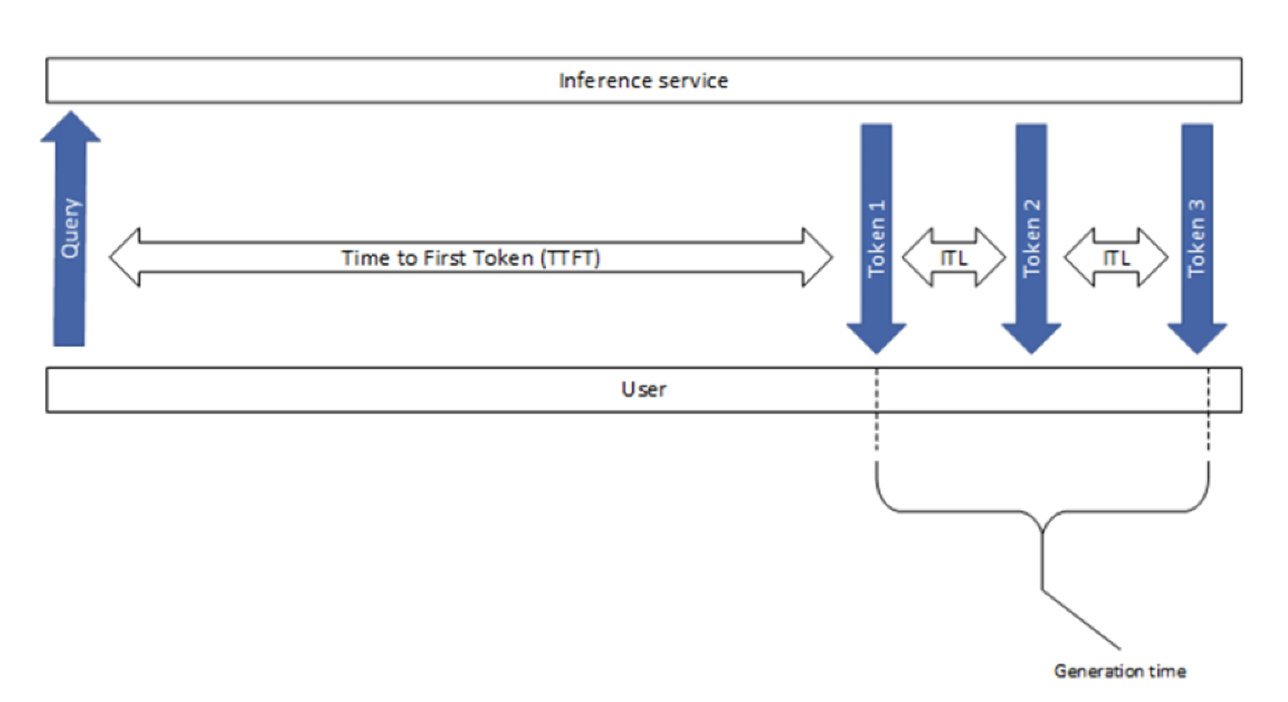


### <font color="yellow">Time To First Token (TTFT) 

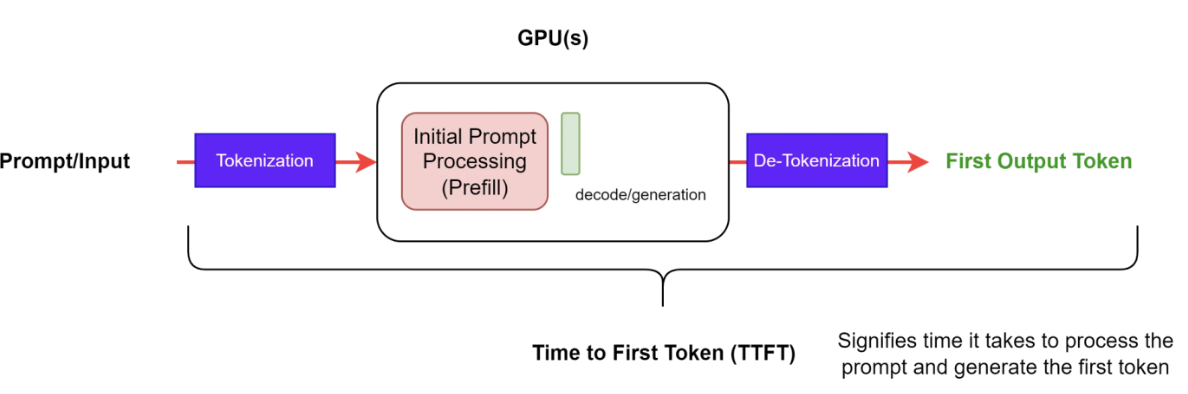

Time to first token generally includes both request queuing time, prefill time and network latency. The longer the prompt, the larger the TTFT. This is because the attention mechanism requires the whole input sequence to compute and create the so-called key-value cache (aka.KV-cache), from which point the iterative generation loop can begin.

### <font color="yellow">End to End Latency(e2e_latency)

This metric indicates how long it takes from submitting a query to receiving the full response, including the performance of your queueing/batching mechanisms and network latencies.

For an individual request, the end-to-end request latency is the time difference between the request sent and the final token received.

e2e_latency = TTFT + Generation Time

### <font color="yellow">Inter Token Latency

This is defined as the average time between consecutive tokens and is also known as time per output token (TPOT).

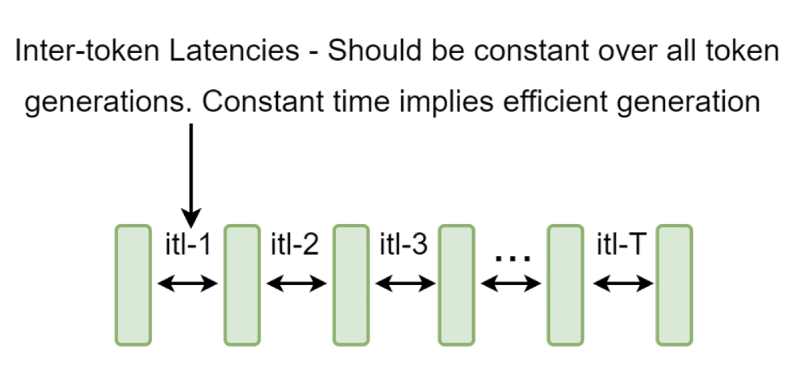

ITL = (e2e_latency - TTFT) / (Number of token - 1)

### <font color="yellow">Token per second (TPS)

Total TPS per system represents the total output tokens per seconds throughput, accounting for all the requests happening simultaneously. As the number of requests increases, the total TPS per system increases, until it reaches a saturation point for all the available GPU compute resources, beyond which it might decrease.

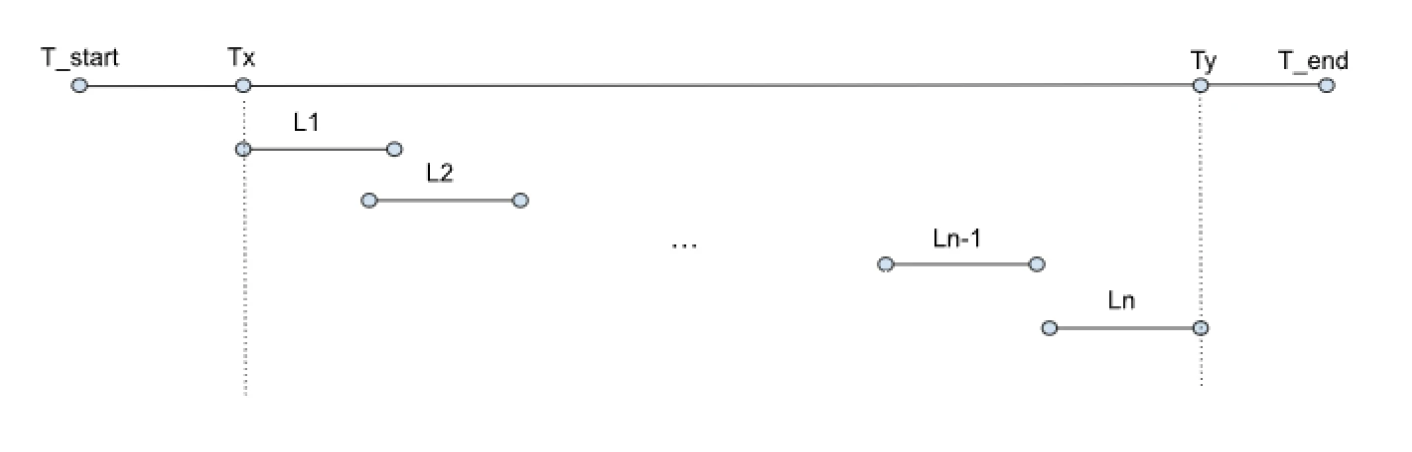

Li : End-to-end latency of i-th request

T_start : start of benchmark

Tx : timestamp of the first request

Ty : timestamp of the last response of the last request

T_end : end of benchmark


GenAI-perf defines the TPS as total output tokens divided by the end-to-end latency between the first request and the last response of the last request.

### <font color="yellow">Requests per Second

This is the average number of requests that can be successfully completed by the system in a 1-second period. It is calculated as:

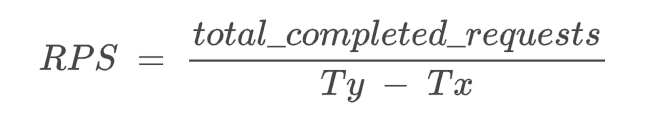


In [1]:
#pip install torch transformers
#pip install accelerate==0.26.0

In [1]:
# !huggingface-cli login --token="<token ID>"

In [ ]:
# Set Some Experiment Hyperparameters
input_prompt = "Write a Poem on Poem"

# Hyperparameters for Testing
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
max_output_length = 100  # Adjust as needed

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import time
from transformers import logging
# Set the logging level to ERROR to suppress warnings and informational messages
logging.set_verbosity_error()

In [ ]:
def benchmark_model(model, tokenizer, input_prompt, batch_size, max_output_length):
    # Tokenize the input prompt
    tokenizer.pad_token = tokenizer.eos_token
    inputs = tokenizer([input_prompt] * batch_size, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs.input_ids.to(model.device)
    attention_mask = inputs.attention_mask.to(model.device)

    # Measure Time to First Token (TTFT)
    start_time = time.time()
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_output_length,
            do_sample=False,
            output_scores=True,
            return_dict_in_generate=True
        )
    
    ttft = time.time() - start_time

    # Measure Inter-Token Latency (ITL)
    token_times = []
    for i in range(max_output_length):
        start_time = time.time()
        with torch.no_grad():
            outputs = model.generate(
                input_ids,
                attention_mask=attention_mask,
                max_new_tokens=i + 1,
                do_sample=False,
                output_scores=True,
                return_dict_in_generate=True
            )
        token_times.append(time.time() - start_time)
    itl = sum(token_times) / len(token_times)

    # Measure Throughput
    total_time = sum(token_times)
    throughput = batch_size * max_output_length / total_time

    return {
        "batch_size": batch_size,
        "ttft": ttft,
        "itl": itl,
        "throughput": throughput
    }

# Vanilla Model

In [ ]:
# Load the vanilla model
model_name = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
vanilla_model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

In [ ]:
# Benchmark the vanilla model
vanilla_metrics = []
for batch_size in batch_sizes:
    metrics = benchmark_model(vanilla_model, tokenizer, input_prompt, batch_size, max_output_length)
    vanilla_metrics.append(metrics)
    print(f"Vanilla Model - Batch Size {batch_size}: {metrics}")

# Weight(INT8) only Quantized Model

In [ ]:
# pip install -U bitsandbytes

In [ ]:
quantized_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_8bit=True,
    device_map="auto",
    torch_dtype=torch.float16
)

weight_only_metrics = []
batch_sizes = [512]

# Benchmark the weight-only quantized model
for batch_size in batch_sizes:
    metrics = benchmark_model(quantized_model, tokenizer, input_prompt, batch_size, max_output_length)
    weight_only_metrics.append(metrics)
    print(f"Weight Quantized Model - Batch Size {batch_size}: {metrics}")

# Neural Magic (LLM Compressor + vLLM) inference - W8A8-INT

In [ ]:
# !pip install llmcompressor
# !pip install https://vllm-wheels.s3.us-west-2.amazonaws.com/nightly/vllm-1.0.0.dev-cp38-abi3-manylinux1_x86_64.whl

In [ ]:
from llmcompressor.modifiers.quantization import GPTQModifier
from llmcompressor.modifiers.smoothquant import SmoothQuantModifier
from llmcompressor.transformers import oneshot

# Select the quantization algorithm. In this case, we:
#   * apply SmoothQuant to make the activations easier to quantize
#   * quantize the weights to int8 with GPTQ (static per channel)
#   * quantize the activations to int8 (dynamic per token)

recipe = [
    SmoothQuantModifier(smoothing_strength=0.8),
    GPTQModifier(scheme="W8A8", targets=["Linear"], ignore=["lm_head"]),
]


# Apply quantization using the built-in open_platypus dataset.
oneshot(
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    dataset="open_platypus",
    recipe=recipe,
    output_dir="Meta-Llama-3.1-8B-Instruct-INT8",
    max_seq_length=2048,
    num_calibration_samples=512,
)

In [ ]:
# Load the Quantized Model
from vllm import LLM
llama31_model = LLM("./Meta-Llama-3.1-8B-Instruct-INT8")

In [ ]:
output = llama31_model.generate(["My name is Lakhan", "My name is Lakhan", "My name is Lakhan"])
print(output[0].outputs[0].text)
print(output[1].outputs[0].text)
print(output[2].outputs[0].text)

In [ ]:
# !pip install torchsummary fvcore

In [ ]:
import torch
import transformers
from transformers import AutoModelForCausalLM
from fvcore.nn import FlopCountAnalysis

def load_model(model_id, torch_dtype=torch.bfloat16, device='cuda'):
    return AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch_dtype).to(device)

def get_model_memory():
    allocated_memory = torch.cuda.memory_allocated() / (1024 ** 3)  # Convert to GB
    reserved_memory = torch.cuda.memory_reserved() / (1024 ** 3)  # Convert to GB
    return allocated_memory, reserved_memory

def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable_params, non_trainable_params

def extract_layer_info(model):
    layer_info = {}
    for name, param in model.named_parameters():
        dtype = str(param.dtype)
        trainable = param.requires_grad
        layer_info[name] = {'dtype': dtype, 'trainable': trainable}
    return layer_info

def calculate_flops(model, dummy_input):
    flops = FlopCountAnalysis(model, dummy_input)
    return flops.total()

def free_memory():
    """Function to clear GPU memory and cache."""
    torch.cuda.empty_cache()

# Load original model (FP16/BF16)
print("Loading the original model...")
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
original_model = load_model(model_id, torch_dtype=torch.bfloat16)

# Dummy input for FLOP calculation
dummy_input = torch.ones(1, 512, dtype=torch.long, device='cuda')

# Extract metrics for original model
print("Extracting metrics for original model...")
original_allocated_memory, original_reserved_memory = get_model_memory()
original_trainable_params, original_non_trainable_params = count_parameters(original_model)
original_flops = calculate_flops(original_model, dummy_input)
original_layer_info = extract_layer_info(original_model)

# Free up memory after extracting metrics for the original model
print("Freeing up memory after original model metrics...")
free_memory()
del original_model  # Delete the model to free up more memory
torch.cuda.empty_cache()  # Extra cache clearance just to be sure

# Load quantized model (INT8)
print("\nLoading the quantized model...")
quantized_model_path = "Meta-Llama-3.1-8B-Instruct-INT8"
quantized_model = AutoModelForCausalLM.from_pretrained(quantized_model_path).to('cuda')

# Extract metrics for quantized model
print("Extracting metrics for quantized model...")
quantized_allocated_memory, quantized_reserved_memory = get_model_memory()
quantized_trainable_params, quantized_non_trainable_params = count_parameters(quantized_model)
quantized_flops = calculate_flops(quantized_model, dummy_input)
quantized_layer_info = extract_layer_info(quantized_model)

# Free memory after extracting metrics for the quantized model
free_memory()

# Create a comparative table
print("\nComparative Metrics Table:")
print(f"{'Metric':<30} {'Original Model':<20} {'Quantized Model':<20}")
print("-" * 70)
print(f"{'Allocated Memory (GB)':<30} {original_allocated_memory:.2f} GB        {quantized_allocated_memory:.2f} GB")
print(f"{'Reserved Memory (GB)':<30} {original_reserved_memory:.2f} GB        {quantized_reserved_memory:.2f} GB")
print(f"{'Trainable Parameters':<30} {original_trainable_params:,}      {quantized_trainable_params:,}")
print(f"{'Non-Trainable Parameters':<30} {original_non_trainable_params:,}      {quantized_non_trainable_params:,}")
print(f"{'FLOPs (Giga)':<30} {original_flops/1e9:.2f} GFLOPs       {quantized_flops/1e9:.2f} GFLOPs")

# Display dtype differences with trainability information for the quantized model
print("\nLayer-wise dtype and trainability comparison (Original vs Quantized):")
print(f"{'Layer Name':<50} {'Original Dtype':<15} {'Quantized Dtype':<15} {'Trainable (Quantized)':<20}")
print("-" * 110)
for layer_name in original_layer_info.keys():
    original_dtype = original_layer_info[layer_name]['dtype']
    quantized_dtype = quantized_layer_info.get(layer_name, {}).get('dtype', "N/A")
    trainable = quantized_layer_info.get(layer_name, {}).get('trainable', "N/A")
    print(f"{layer_name:<50} {original_dtype:<15} {quantized_dtype:<15} {str(trainable):<20}")


In [ ]:
import torch
import time
import numpy as np
from vllm import LLM, SamplingParams

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

if 0 : 
    def benchmark_model_over_batch_sizes(model, sampling_params, input_prompt, batch_sizes):
        
        results = []
    
        # Loop over each batch size
        for batch_size in batch_sizes:
            print(f"Processing Batch Size : {batch_size} ...")
            # Tokenize the input prompt and replicate for the given batch size
            # tokenizer.pad_token = tokenizer.eos_token
            
            batch_input = [input_prompt] * batch_size
            
            #input_ids = inputs.input_ids.to(model.device)
            #attention_mask = inputs.attention_mask.to(model.device)
    
            # Measure Time to First Token (TTFT)
            start_time = time.time()
            with torch.no_grad():
                outputs = model.generate(
                    batch_input,
                    #attention_mask=attention_mask,
                    #max_new_tokens=max_output_length,
                    sampling_params,
                    #output_scores=True,
                    #return_dict_in_generate=True,
                    use_tqdm=False
                )
            ttft = time.time() - start_time
    
            # Measure Inter-Token Latency (ITL)
            token_times = []
            max_output_length = 100
            for i in range(max_output_length):
                start_time = time.time()
                sampling_params.max_tokens = i+1
                with torch.no_grad():
                    outputs = model.generate(
                        batch_input,
                        sampling_params,
                        use_tqdm=False
                    )
                token_times.append(time.time() - start_time)
            itl = sum(token_times) / len(token_times)
    
            # Measure Throughput
            total_time = sum(token_times)
            throughput = batch_size * max_output_length / total_time
    
            # Store results for this batch size
            results.append({
                "batch_size": batch_size,
                "ttft": ttft,
                "itl": itl,
                "throughput": throughput
            })
    
        return results
    
    
    # Hyperparameters for Benchmarking
    input_prompt = "Write a Poem on Poem"
    batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
    #batch_sizes = [2048]
    
    sampling_params = SamplingParams(max_tokens=100, temperature=0.1)
    
    # Run the benchmarking function for different batch sizes
    benchmark_results = benchmark_model_over_batch_sizes(
        model=llama31_model,
        sampling_params=sampling_params,
        input_prompt=input_prompt, 
        batch_sizes=batch_sizes,
        
    )
    
    # Print the results
    for result in benchmark_results:
        print(f"Batch Size: {result['batch_size']}")
        print(f"Time to First Token (TTFT): {result['ttft']:.4f} seconds")
        print(f"Inter-Token Latency (ITL): {result['itl']:.4f} seconds")
        print(f"Throughput: {result['throughput']:.4f} tokens/second")
        print("-" * 50)


### Vanilla Model

| Batch Size | TTFT (seconds) | ITL (seconds) | Throughput (tokens/second) |
|------------|----------------|---------------|----------------------------|
| 1          | 2.8133         | 1.4192        | 0.7046                     |
| 2          | 2.9321         | 1.4133        | 1.4152                     |
| 4          | 2.7489         | 1.4524        | 2.7540                     |
| 8          | 2.9743         | 1.4615        | 5.4738                     |
| 16         | 2.9221         | 1.4266        | 11.2152                    |
| 32         | 2.8105         | 1.4830        | 21.5782                    |
| 64         | 2.9124         | 1.4228        | 44.9816                    |
| 128        | 3.8221         | 1.7786        | 71.9673                    |
| 256        | 6.3656         | 2.8693        | 89.2198                    |

### Weight Quant Model

| Batch Size | TTFT (seconds) | ITL (seconds) | Throughput (tokens/second) |
|------------|----------------|---------------|----------------------------|
| 1          | 12.4743        | 6.4094        | 0.1560                     |
| 2          | 13.3130        | 6.6475        | 0.3009                     |
| 4          | 12.6257        | 6.4432        | 0.6208                     |
| 8          | 12.9742        | 6.6808        | 1.1975                     |
| 16         | 13.0259        | 6.5851        | 2.4297                     |
| 32         | 13.1244        | 6.3189        | 5.0642                     |
| 64         | 12.6326        | 6.3842        | 10.0248                    |
| 128        | 13.9507        | 6.6457        | 19.2606                    |
| 256        | 14.7444        | 7.2858        | 35.1367                    |

### Weight Activation Quant Model

| Batch Size | TTFT (seconds) | ITL (seconds) | Throughput (tokens/second) |
|------------|----------------|---------------|----------------------------|
| 1          | 0.9248         | 0.4666        | 2.1430                     |
| 2          | 0.9150         | 0.4702        | 4.2535                     |
| 4          | 0.9362         | 0.4795        | 8.3416                     |
| 8          | 0.9589         | 0.4923        | 16.2505                    |
| 16         | 1.0093         | 0.5206        | 30.7318                    |
| 32         | 1.1286         | 0.5819        | 54.9916                    |
| 64         | 1.3970         | 0.7319        | 87.4400                    |
| 128        | 1.9309         | 1.0428        | 122.7521                   |
| 256        | 3.3002         | 1.8158        | 140.9817                   |
| 512        | 6.5633         | 3.6052        | 142.0183                   |

In [2]:
# Experimentation Generated Data

data = {
    "Vanilla_Model": {
        "Batch Size 1": {"batch_size": 1, "ttft": 2.813289165496826, "itl": 1.4192354559898377, "throughput": 0.7046047192377644},
        "Batch Size 2": {"batch_size": 2, "ttft": 2.9320781230926514, "itl": 1.4132583451271057, "throughput": 1.4151694252476703},
        "Batch Size 4": {"batch_size": 4, "ttft": 2.7489192485809326, "itl": 1.4524271440505983, "throughput": 2.7540107718206155},
        "Batch Size 8": {"batch_size": 8, "ttft": 2.974278688430786, "itl": 1.461504499912262, "throughput": 5.473811404946247},
        "Batch Size 16": {"batch_size": 16, "ttft": 2.9220774173736572, "itl": 1.4266332912445068, "throughput": 11.215215639642468},
        "Batch Size 32": {"batch_size": 32, "ttft": 2.8104705810546875, "itl": 1.482977604866028, "throughput": 21.578208527896738},
        "Batch Size 64": {"batch_size": 64, "ttft": 2.912440299987793, "itl": 1.4228033089637757, "throughput": 44.981621561318306},
        "Batch Size 128": {"batch_size": 128, "ttft": 3.8221051692962646, "itl": 1.7785850262641907, "throughput": 71.96732127496665},
        "Batch Size 256": {"batch_size": 256, "ttft": 6.365599155426025, "itl": 2.8693181324005126, "throughput": 89.2198035168121}
    },
    "Weight_Quant_Model": {
        "Batch Size 1": {"batch_size": 1, "ttft": 12.474268198013306, "itl": 6.4094228935241695, "throughput": 0.15602028710109936},
        "Batch Size 2": {"batch_size": 2, "ttft": 13.312956094741821, "itl": 6.647535433769226, "throughput": 0.3008633831179111},
        "Batch Size 4": {"batch_size": 4, "ttft": 12.625734090805054, "itl": 6.443225457668304, "throughput": 0.6208070827693081},
        "Batch Size 8": {"batch_size": 8, "ttft": 12.974172592163086, "itl": 6.680834491252899, "throughput": 1.1974551997170804},
        "Batch Size 16": {"batch_size": 16, "ttft": 13.025932550430298, "itl": 6.58512818813324, "throughput": 2.4297173180064853},
        "Batch Size 32": {"batch_size": 32, "ttft": 13.124436616897583, "itl": 6.318875014781952, "throughput": 5.064192585727894},
        "Batch Size 64": {"batch_size": 64, "ttft": 12.632570743560791, "itl": 6.384198076725006, "throughput": 10.024751618112544},
        "Batch Size 128": {"batch_size": 128, "ttft": 13.950710773468018, "itl": 6.6457083344459535, "throughput": 19.260550351954507},
        "Batch Size 256": {"batch_size": 256, "ttft": 14.744359731674194, "itl": 7.285836606025696, "throughput": 35.136664990301476}
    },
    
    "Weight_Activation_Quant_Model": {
        "Batch Size 1": {"batch_size": 1, "ttft": 0.9248, "itl": 0.4666, "throughput": 2.1430},
        "Batch Size 2": {"batch_size": 2, "ttft": 0.9150, "itl": 0.4702, "throughput": 4.2535},
        "Batch Size 4": {"batch_size": 4, "ttft": 0.9362, "itl": 0.4795, "throughput": 8.3416},
        "Batch Size 8": {"batch_size": 8, "ttft": 0.9589, "itl": 0.4923, "throughput": 16.2505},
        "Batch Size 16": {"batch_size": 16, "ttft": 1.0093, "itl": 0.5206, "throughput": 30.7318},
        "Batch Size 32": {"batch_size": 32, "ttft": 1.1286, "itl": 0.5819, "throughput": 54.9916},
        "Batch Size 64": {"batch_size": 64, "ttft": 1.3970, "itl": 0.7319, "throughput": 87.4400},
        "Batch Size 128": {"batch_size": 128, "ttft": 1.9309, "itl": 1.0428, "throughput": 122.7521},
        "Batch Size 256": {"batch_size": 256, "ttft": 3.3002, "itl": 1.8158, "throughput": 140.9817},
        "Batch Size 512": {"batch_size": 512, "ttft": 6.5633, "itl": 3.6052, "throughput": 142.0183}

    
    }
}


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


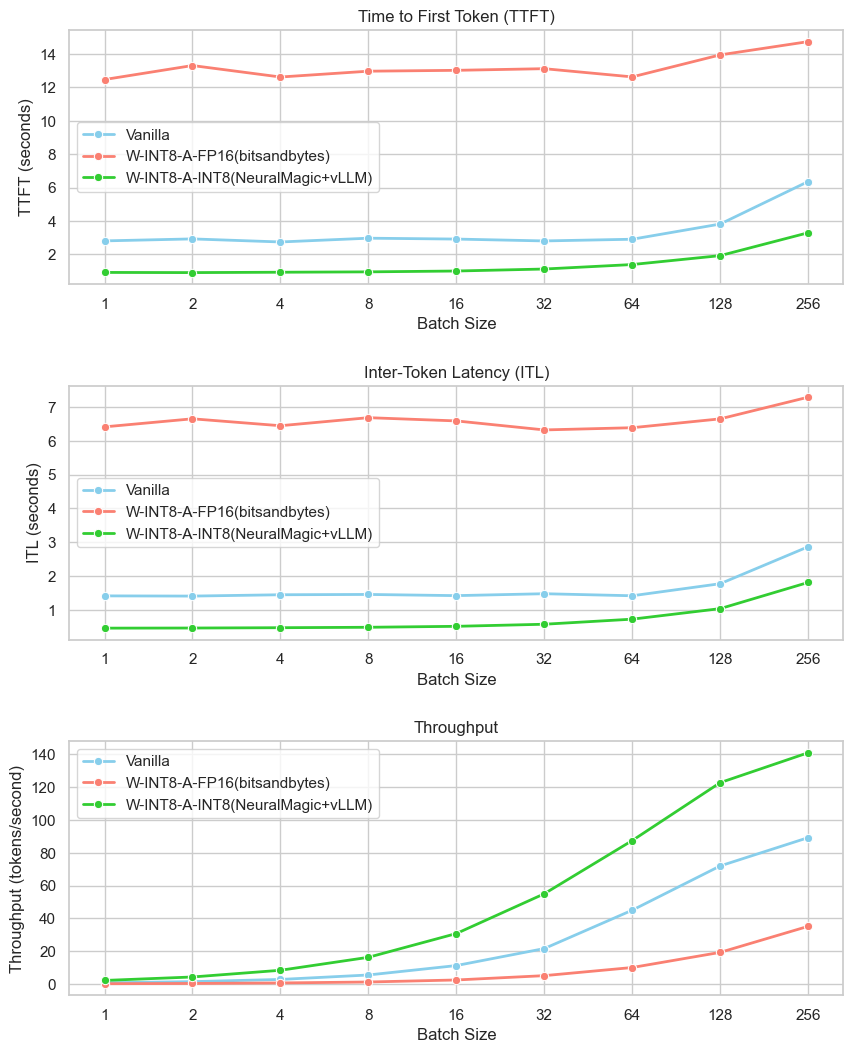

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up seaborn style
sns.set_theme(style="whitegrid")

# X-axis labels for batch sizes (using strings for evenly spaced labels) - trimmed to 9 to match data lengths
x_labels = ["1", "2", "4", "8", "16", "32", "64", "128", "256"]

# Data values (aligned in length with x_labels)
ttft_vanilla = [2.8133, 2.9321, 2.7489, 2.9743, 2.9221, 2.8105, 2.9124, 3.8221, 6.3656]
itl_vanilla = [1.4192, 1.4133, 1.4524, 1.4615, 1.4266, 1.4830, 1.4228, 1.7786, 2.8693]
throughput_vanilla = [0.7046, 1.4152, 2.7540, 5.4738, 11.2152, 21.5782, 44.9816, 71.9673, 89.2198]

ttft_weight_only = [12.4743, 13.3130, 12.6257, 12.9742, 13.0259, 13.1244, 12.6326, 13.9507, 14.7444]
itl_weight_only = [6.4094, 6.6475, 6.4432, 6.6808, 6.5851, 6.3189, 6.3842, 6.6457, 7.2858]
throughput_weight_only = [0.1560, 0.3009, 0.6208, 1.1975, 2.4297, 5.0642, 10.0248, 19.2606, 35.1367]

ttft_weight_activation = [0.9248, 0.9150, 0.9362, 0.9589, 1.0093, 1.1286, 1.3970, 1.9309, 3.3002]
itl_weight_activation = [0.4666, 0.4702, 0.4795, 0.4923, 0.5206, 0.5819, 0.7319, 1.0428, 1.8158]
throughput_weight_activation = [2.1430, 4.2535, 8.3416, 16.2505, 30.7318, 54.9916, 87.4400, 122.7521, 140.9817]

# Set up figure and axis grid layout
#fig, axs = plt.subplots(3, 1, figsize=(10, 15))
fig, axs = plt.subplots(3, 1, figsize=(9, 11))  # Reduced size from (10, 15) to (8, 10)


# Plot Time to First Token (TTFT)
sns.lineplot(ax=axs[0], x=x_labels, y=ttft_vanilla, label="Vanilla", marker="o", linewidth=2, color="skyblue")
sns.lineplot(ax=axs[0], x=x_labels, y=ttft_weight_only, label="W-INT8-A-FP16(bitsandbytes)", marker="o", linewidth=2, color="salmon")
sns.lineplot(ax=axs[0], x=x_labels, y=ttft_weight_activation, label="W-INT8-A-INT8(NeuralMagic+vLLM)", marker="o", linewidth=2, color="limegreen")
axs[0].set_title("Time to First Token (TTFT)")
axs[0].set_xlabel("Batch Size")
axs[0].set_ylabel("TTFT (seconds)")

# Plot Inter-Token Latency (ITL)
sns.lineplot(ax=axs[1], x=x_labels, y=itl_vanilla, label="Vanilla", marker="o", linewidth=2, color="skyblue")
sns.lineplot(ax=axs[1], x=x_labels, y=itl_weight_only, label="W-INT8-A-FP16(bitsandbytes)", marker="o", linewidth=2, color="salmon")
sns.lineplot(ax=axs[1], x=x_labels, y=itl_weight_activation, label="W-INT8-A-INT8(NeuralMagic+vLLM)", marker="o", linewidth=2, color="limegreen")
axs[1].set_title("Inter-Token Latency (ITL)")
axs[1].set_xlabel("Batch Size")
axs[1].set_ylabel("ITL (seconds)")

# Plot Throughput
sns.lineplot(ax=axs[2], x=x_labels, y=throughput_vanilla, label="Vanilla", marker="o", linewidth=2, color="skyblue")
sns.lineplot(ax=axs[2], x=x_labels, y=throughput_weight_only, label="W-INT8-A-FP16(bitsandbytes)", marker="o", linewidth=2, color="salmon")
sns.lineplot(ax=axs[2], x=x_labels, y=throughput_weight_activation, label="W-INT8-A-INT8(NeuralMagic+vLLM)", marker="o", linewidth=2, color="limegreen")
axs[2].set_title("Throughput")
axs[2].set_xlabel("Batch Size")
axs[2].set_ylabel("Throughput (tokens/second)")

# Adjust layout with tighter padding
plt.tight_layout(pad=2)  # Set padding between subplots

# Display the plots
plt.show()


# Discussion

### TL;DR for Performance Benchmarking of Llama 3.1-8B Model on A100 80GB (Single GPU) with Varying Batch Sizes

In our benchmarking, we analyzed the **Vanilla**, **W-INT8-A-FP16 (bitsandbytes)**, and **W-INT8-A-INT8 (NeuralMagic+vLLM)** models across various batch sizes to evaluate their **Time to First Token (TTFT)**, **Inter-Token Latency (ITL)**, and **Throughput**. Here’s a consolidated summary of the findings:

---

#### 1. **Time to First Token (TTFT)**
   - **Interpretation**: TTFT reflects the latency for the initial response after a prompt, which is critical for applications needing low response times.
   - **Insights**:
     - **Vanilla Model**: TTFT stays relatively stable across batch sizes, suggesting it handles initial token processing efficiently even as batch size grows.
     - **W-INT8-A-FP16 (bitsandbytes)**: TTFT is consistently high, indicating significant latency overhead, likely due to quantization/dequantization overheads.
     - **W-INT8-A-INT8 (NeuralMagic+vLLM)**: Exhibits the lowest TTFT, especially at higher batch sizes, showing strong efficiency for prompt-to-response latency.
   - **Conclusion**: For applications sensitive to initial response latency, the **W-INT8-A-INT8** model (NeuralMagic+vLLM) is the best choice, followed by the **Vanilla model**. The **W-INT8-A-FP16** model is less suitable due to high TTFT.

---

#### 2. **Inter-Token Latency (ITL)**
   - **Interpretation**: ITL measures the delay between generating consecutive tokens, which is vital for tasks generating long sequences of text.
   - **Insights**:
     - **Vanilla Model**: Moderate ITL that increases slightly at higher batch sizes, indicating that token processing scales decently but begins to degrade with larger batches.
     - **W-INT8-A-FP16 (bitsandbytes)**: High ITL across all batch sizes, suggesting a consistent but high latency per token, possibly from constant quantization overhead.
     - **W-INT8-A-INT8 (NeuralMagic+vLLM)**: Extremely low ITL with only a slight increase at larger batch sizes, showing superior scalability and efficiency for token generation.
   - **Conclusion**: **W-INT8-A-INT8 (NeuralMagic+vLLM)** is the most efficient for inter-token processing, making it ideal for high-throughput applications requiring fast, scalable token generation. **Vanilla** performs reasonably well for smaller batches, while **W-INT8-A-FP16** is less efficient due to consistently high ITL.

---

#### 3. **Throughput**
   - **Interpretation**: Throughput measures tokens generated per second, indicating the model’s efficiency for high-output tasks.
   - **Insights**:
     - **Vanilla Model**: Throughput increases linearly with batch size, handling more tokens effectively at larger batches but with a gradual plateau.
     - **W-INT8-A-FP16 (bitsandbytes)**: Consistently lower throughput compared to other models, making it less optimal for high-throughput requirements.
     - **W-INT8-A-INT8 (NeuralMagic+vLLM)**: Highest throughput at all batch sizes, scaling well even at the maximum batch size of 256, demonstrating its robustness in handling large input batches efficiently.
   - **Conclusion**: For tasks requiring high token output per second, **W-INT8-A-INT8 (NeuralMagic+vLLM)** is the best choice, followed by the **Vanilla model**. The **W-INT8-A-FP16** model is less suitable due to lower throughput.

---

### **Overall Insights**
   - **Best Overall Performer**: The **W-INT8-A-INT8 (NeuralMagic+vLLM)** model demonstrates the best performance across TTFT, ITL, and throughput metrics, especially at higher batch sizes. This makes it ideal for large-scale, high-speed applications requiring both low latency and high throughput.
   - **Moderate Performance**: The **Vanilla model** performs reasonably well, especially at smaller batch sizes. It shows decent scalability but begins to experience latency and throughput limitations as batch size increases.
   - **Less Suitable Model**: The **W-INT8-A-FP16 (bitsandbytes)** model shows consistent latency overhead in TTFT and ITL, with lower throughput, likely due to quantization bottlenecks. It may be beneficial for memory-limited scenarios but is less optimal for latency and throughput-sensitive tasks.

---

### **Recommendation Summary**
For applications with a focus on high efficiency and scalability in token generation:
- **Choose W-INT8-A-INT8 (NeuralMagic+vLLM)** for high-speed, high-throughput requirements.
- **Choose Vanilla** for moderate batch sizes and applications that don’t strictly require the lowest latency or highest throughput.
- **Avoid W-INT8-A-FP16 (bitsandbytes)** in latency-critical or throughput-intensive environments due to its higher latency and lower throughput performance.